<img src="https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Keras Clasificación

# Redes neuronales de una sola capa oculta (ANN)

In [ ]:
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchsummary

from  sklearn import  datasets

## 1 - Perceptron & Clasificación binaria

In [ ]:
df_drugs = pd.DataFrame({
      "Age": [0, 1, 2, 0],
      "cholesterol": [0, 1 , 1, 0],
      "drug": [0, 1, 1, 0]}
      )
df_drugs

,Age,cholesterol,drug
0,0,0,0
1,1,1,1
2,2,1,1
3,0,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_norm = df_drugs.copy()
df_norm.loc[:, 'Age'] = scaler.fit_transform(df_norm[['Age']])
df_norm.loc[:, 'cholesterol'] = scaler.fit_transform(df_norm[['cholesterol']])
df_norm.head()

,Age,cholesterol,drug
0,0.0,0.0,0
1,0.5,1.0,1
2,1.0,1.0,1
3,0.0,0.0,0


In [ ]:
X = df_norm.drop('drug', axis=1).values
y = df_norm['drug'].values

In [ ]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 2
Output dim 1


In [ ]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(in_features=input_dim, out_features=output_dim) # fully connected layer
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.fc(x))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.5)
model1_criterion = torch.nn.BCELoss()  # Para clasificación binaria

torchsummary.summary(model1, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 1]               3
           Sigmoid-2                 [-1, 1, 1]               0
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc

In [ ]:
def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()
            
            # Calculo el accuracy del batch
            accuracy = binary_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }
    
    return history

history1 = train(model1,
                data_set,
                model1_optimizer,
                model1_criterion,
                epochs=10
                )

Epoch: 1/10 - Train loss 0.651 - Train accuracy 0.500
Epoch: 2/10 - Train loss 0.307 - Train accuracy 1.000
Epoch: 3/10 - Train loss 0.195 - Train accuracy 1.000
Epoch: 4/10 - Train loss 0.111 - Train accuracy 1.000
Epoch: 5/10 - Train loss 0.063 - Train accuracy 1.000
Epoch: 6/10 - Train loss 0.039 - Train accuracy 1.000
Epoch: 7/10 - Train loss 0.028 - Train accuracy 1.000
Epoch: 8/10 - Train loss 0.022 - Train accuracy 1.000
Epoch: 9/10 - Train loss 0.018 - Train accuracy 1.000
Epoch: 10/10 - Train loss 0.015 - Train accuracy 1.000


## 2 - Red neuronal (ANN) & clasificación multicategorica

### `Penguins dataset`:
El dataset **`Penguins`** es un dataset alternativo al clásico dataset de **`iris`**, el cual se lo utiliza para clasificación multicagórica (3 especies de pinguinos). Cada especie se caracteriza por su tamaño, como podrá ver en el dataset.<br> [Dataset source](https://www.kaggle.com/parulpandey/penguin-dataset-the-new-iris/data)

In [ ]:
if os.access('penguins_dataset.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/penguins_dataset.csv > penguins_dataset.csv
    else:
        !wget penguins_dataset.csv https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/penguins_dataset.csv

--2022-06-15 22:33:10--  http://penguins_dataset.csv/
Resolving penguins_dataset.csv (penguins_dataset.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘penguins_dataset.csv’
--2022-06-15 22:33:10--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/penguins_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50571 (49K) [text/plain]
Saving to: ‘penguins_dataset.csv’

penguins_dataset.cs 100%[===================>]  49.39K  --.-KB/s    in 0.007s  

2022-06-15 22:33:10 (7.07 MB/s) - ‘penguins_dataset.csv’ saved [50571/50571]

FINISHED --2022-06-15 22:33:10--
Total wall clock time: 0.3s
Downloaded: 1 files, 49K in 0.007s (7.07 MB/s)


In [ ]:
df2 = pd.read_csv("penguins_dataset.csv")
df2.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [ ]:
# Analizar cantidad de faltantes
des = df2.describe()
des.loc['Nan'] = df2.isna().sum()
des.loc['%Nan'] = (df2.isna().mean())*100
des

,Sample Number,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
count,344.000000,342.000000,342.000000,342.000000,342.000000,330.000000,331.000000
mean,63.151163,43.921930,17.151170,200.915205,4201.754386,8.733382,-25.686292
std,40.430199,5.459584,1.974793,14.061714,801.954536,0.551770,0.793961
min,1.000000,32.100000,13.100000,172.000000,2700.000000,7.632200,-27.018540
25%,29.000000,39.225000,15.600000,190.000000,3550.000000,8.299890,-26.320305
50%,58.000000,44.450000,17.300000,197.000000,4050.000000,8.652405,-25.833520
75%,95.250000,48.500000,18.700000,213.000000,4750.000000,9.172123,-25.062050
max,152.000000,59.600000,21.500000,231.000000,6300.000000,10.025440,-23.787670
Nan,0.000000,2.000000,2.000000,2.000000,2.000000,14.000000,13.000000
%Nan,0.000000,0.581395,0.581395,0.581395,0.581395,4.069767,3.779070


In [ ]:
# Eliminar faltantes y seleccionar columnas
df2_clean = df2[["Species", "Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]]
df2_clean = df2_clean.dropna()
df2_clean.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df2_norm = df2_clean.copy()
df2_norm["target"] = le.fit_transform(df2_norm['Species'])
df2_norm = df2_norm.drop(["Species"], axis=1)

from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
df2_norm.loc[:, 'Culmen Length (mm)'] = scaler2.fit_transform(df2_norm[['Culmen Length (mm)']])
df2_norm.loc[:, 'Culmen Depth (mm)'] = scaler2.fit_transform(df2_norm[['Culmen Depth (mm)']])
df2_norm.loc[:, 'Culmen Depth (mm)'] = scaler2.fit_transform(df2_norm[['Culmen Depth (mm)']])
df2_norm.loc[:, 'Flipper Length (mm)'] = scaler2.fit_transform(df2_norm[['Flipper Length (mm)']])
df2_norm.loc[:, 'Body Mass (g)'] = scaler2.fit_transform(df2_norm[['Body Mass (g)']])

df2_norm.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),target
0,-0.884499,0.785449,-1.418347,-0.564142,0
1,-0.811126,0.126188,-1.062250,-0.501703,0
2,-0.664380,0.430462,-0.421277,-1.188532,0
3,-1.324737,1.089724,-0.563715,-0.938776,0
4,-0.847812,1.748985,-0.777373,-0.689020,0


In [ ]:
X2 = df2_norm.drop("target", axis=1).values
y2 = df2_norm["target"].values

In [ ]:
class Data2(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss unfction esperan la salida float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=3).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set2 = Data2(X2, y2)

input_dim2 = data_set2.x.shape[1]
print("Input dim", input_dim2)

output_dim2 = data_set2.y.shape[1]
print("Output dim", output_dim2)

Input dim 4
Output dim 3


In [ ]:
# Utilizamos "random_split" para crear los datos de train y test
# partir del conjunto de datos_set
# Fijamos un "seed" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
torch.manual_seed(42)
valid_set_size2 = int(data_set2.len * 0.2)
test_set_size2 = int(data_set2.len * 0.1)
train_set_size2 = data_set2.len - valid_set_size2 - test_set_size2
train_set2, valid_test_set2 = torch.utils.data.random_split(data_set2, [train_set_size2, data_set2.len - train_set_size2])
valid_set2, test_set2 = torch.utils.data.random_split(valid_test_set2, [valid_set_size2, len(valid_test_set2) - valid_set_size2])

print("Tamaño del conjunto de entrenamiento:", len(train_set2))
print("Tamaño del conjunto de validacion:", len(valid_set2))
print("Tamaño del conjunto de test:", len(test_set2))

train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=32, shuffle=True)
valid_loader2 = torch.utils.data.DataLoader(valid_set2, batch_size=len(valid_set2), shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=len(test_set2), shuffle=True)

Tamaño del conjunto de entrenamiento: 240
Tamaño del conjunto de validacion: 68
Tamaño del conjunto de test: 34


In [ ]:
class Model2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=3) # fully connected layer
        self.fc2 = nn.Linear(in_features=3, out_features=output_dim) # fully connected layer
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x):
        out = self.sigmoid(self.fc1(x))
        out = self.softmax(self.fc2(out))
        return out

# Crear el modelo basado en la arquitectura definida
model2 = Model2(input_dim=input_dim2, output_dim=output_dim2)
# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model2, input_size=(1, input_dim2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 3]              15
           Sigmoid-2                 [-1, 1, 3]               0
            Linear-3                 [-1, 1, 3]              12
           Softmax-4                 [-1, 1, 3]               0
Total params: 27
Trainable params: 27
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
def categorical_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=1,keepdim=True)[1]

    correct_results_sum = (y_pred_tag == y_test_tag).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc

In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            # Realizo el forward pass de nuestro modelo
            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()
            
            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).next()
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

history2 = train(model2, 
                train_loader2,
                valid_loader2,
                model2_optimizer,
                model2_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 1.115 - Train accuracy 0.301 - Valid Loss 1.081 - Valid accuracy 0.471
Epoch: 2/100 - Train loss 1.113 - Train accuracy 0.293 - Valid Loss 1.079 - Valid accuracy 0.471
Epoch: 3/100 - Train loss 1.108 - Train accuracy 0.309 - Valid Loss 1.078 - Valid accuracy 0.471
Epoch: 4/100 - Train loss 1.106 - Train accuracy 0.301 - Valid Loss 1.075 - Valid accuracy 0.471
Epoch: 5/100 - Train loss 1.106 - Train accuracy 0.285 - Valid Loss 1.073 - Valid accuracy 0.471
Epoch: 6/100 - Train loss 1.102 - Train accuracy 0.293 - Valid Loss 1.071 - Valid accuracy 0.471
Epoch: 7/100 - Train loss 1.100 - Train accuracy 0.285 - Valid Loss 1.069 - Valid accuracy 0.471
Epoch: 8/100 - Train loss 1.095 - Train accuracy 0.293 - Valid Loss 1.067 - Valid accuracy 0.471
Epoch: 9/100 - Train loss 1.092 - Train accuracy 0.289 - Valid Loss 1.065 - Valid accuracy 0.471
Epoch: 10/100 - Train loss 1.087 - Train accuracy 0.305 - Valid Loss 1.063 - Valid accuracy 0.471
Epoch: 11/100 - Train loss 1.

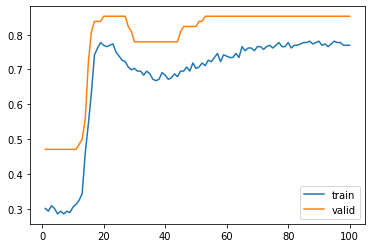

In [ ]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

In [ ]:
test_data, test_target = iter(test_loader2).next()
output = model2(test_data)

# Calcular el loss
test_loss = model2_criterion(output, test_target).item()
# Calcular accuracy
test_accuracy = categorical_acc(output, test_target).item()

print("El modelo logro un error de {:.3f} y una accuracy de {:.3f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.807 y una accuracy de 0.912
